In [1]:
import sys,os
import numpy as np
import pandas as pd
import random
import math
from time import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns


sys.path.append('unpast/') # path to UnPaSt
from unpast.run_unpast import unpast

from unpast.utils.method import prepare_input_matrix, zscore
from unpast.utils.io import read_bic_table, write_bic_table 

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
exprs_file = "../data/UKE_244.exprs.tsv.gz" 
annot = pd.read_csv("../data/UKE.sample_annotation_v4_181samples.tsv",sep ="\t",index_col=0)

out_dir = "unpast_results/" 
basename = 'UKE_244'

exprs = pd.read_csv(exprs_file,sep="\t",index_col=0)
print(exprs.shape)
exprs.head(3)

(23758, 244)


,T0063,T0096,T0103,T0249,T0294,T0305,T0315,T0342,T0430,T0644,...,T6985,T6987,T6990,T6991,T6993,T6995,T6999,T7001,T7002,T7003
ENSG00000012124,9.027778,7.575057,7.261707,9.946216,9.903127,7.871454,9.29040,9.726680,9.152180,9.247163,...,5.218529,5.232677,7.880272,4.017847,7.706173,4.629797,5.397713,8.116292,9.344000,9.764757
ENSG00000260083,3.660087,3.141124,2.923667,3.939617,3.530985,3.802634,3.37083,3.531991,3.817024,4.534004,...,2.437952,2.449817,3.532084,3.738694,2.859947,4.268662,3.101250,1.871275,2.633388,1.929429
ENSG00000176887,9.648030,4.776085,6.083604,7.272087,2.432884,6.795860,0.00000,6.245121,8.322694,3.000023,...,8.648666,6.330015,8.254377,3.632195,3.616804,4.629797,5.111689,4.083328,6.367058,5.607441


In [3]:
# functions to rename genes 
gene_info = pd.read_csv("../data/gene_id_mapping.tsv", sep ="\t",index_col=0)
gene_info.set_index("ensembl_gene_id",inplace=True)
ens2hgnc = gene_info["hgnc_symbol"].dropna().to_dict() 
def rename_gene(g,mapper=ens2hgnc, not_mapped = "", keep_not_mapped = False):
    if g in ens2hgnc.keys():
        return mapper[g]
    else:
        if keep_not_mapped:
            return g
        else:
            return not_mapped
        
def rename_genes_in_biclusters(biclusters, rename_gene_func = rename_gene):
    renamed_biclusters = biclusters.copy()
    renamed_biclusters["genes"] = renamed_biclusters["genes"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    renamed_biclusters["genes_up"] = renamed_biclusters["genes_up"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    renamed_biclusters["genes_down"] = renamed_biclusters["genes_down"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    return renamed_biclusters

def rename_genes_in_exprs(data, rename_gene_func = rename_gene):
    renamed_data = data.copy()
    renamed_data.index = [rename_gene_func(x, keep_not_mapped=True) for x in renamed_data.index ]
    # drop duplicates 
    renamed_data = renamed_data[~renamed_data.index.duplicated()]
    return renamed_data

In [4]:
analysis_seed =  42
n_runs = 10
seeds = []
random.seed(analysis_seed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)
biclusters = []

generate  10  seeds [670487, 116739, 26225, 777572, 288389, 256787, 234053, 146316, 772246, 107473]


In [5]:
suffix = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"
biclusters = []
for seed in seeds:
    # find and save biclusters
    fname = out_dir+basename+".seed="+str(seed)+suffix
    if not os.path.exists(fname):
        results = unpast(exprs_file,
                      basename,
                      out_dir=out_dir,
                      #load=True,
                      seed = seed,
                      verbose = False
                     )
    else:
        results = read_bic_table(fname)
    # make bicluster ids unique: 'seed=<seed>_<bicluster id>'
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values ]
    biclusters.append(results)
    print("seed=%s\tn_biclusters: %s"%(seed, results.shape[0]))


seed=670487	n_biclusters: 205
seed=116739	n_biclusters: 228
seed=26225	n_biclusters: 208
seed=777572	n_biclusters: 201
seed=288389	n_biclusters: 194
seed=256787	n_biclusters: 213
seed=234053	n_biclusters: 215
seed=146316	n_biclusters: 200
seed=772246	n_biclusters: 197
seed=107473	n_biclusters: 227


In [6]:
from unpast.utils.consensus import make_consensus_biclusters
# filter and z-score transform input matrix, limit z-scores to [-3,3]
exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
uke_bics =  make_consensus_biclusters(biclusters,
                                      exprs_z, 
                                                 seed = analysis_seed,
                                                 verbose = True,
                                                 frac_runs=0.2,
                                                 plot = False
                                                )


uke_bics.head(5)

218 s for similarity matrix
	Running Louvain ...
		modularity: newman
	curve type: increasing
	Louvain runtime: modules detected in 5.06 s.
	modules: 234, not clustered features 49 
		similarity cutoff: 0.43 modularity: 0.994
keep genes included in at least 2 merged biclusters
all consensus biclusters: 283
detected 2+ times:234
8 s for making consensus biclusters from consensus gene sets


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
0,3.348530,2,111,"{ENSG00000204792, ENSG00000236209}","{T6732, T6656, T2497, T7003, T5741, T6787, T66...",{},"{ENSG00000204792, ENSG00000236209}","{19402, 22351}","{1, 2, 5, 7, 9, 10, 14, 21, 22, 23, 24, 25, 29...",DOWN,10,"{seed=26225_0, seed=116739_1, seed=146316_0, s..."
1,2.673952,2,75,"{ENSG00000241945, ENSG00000160221}","{T6897, T6898, T6679, T2434, T7002, T6068, T67...","{ENSG00000241945, ENSG00000160221}",{},"{22705, 3483}","{130, 131, 133, 134, 139, 14, 15, 16, 17, 18, ...",UP,10,"{seed=107473_3, seed=146316_4, seed=288389_3, ..."
2,2.454886,2,57,"{ENSG00000187010, ENSG00000261349}","{T6159, T6732, T6656, T1702, T6991, T6706, T69...",{},"{ENSG00000187010, ENSG00000261349}","{9330, 21459}","{128, 1, 2, 3, 133, 134, 135, 8, 136, 11, 12, ...",DOWN,7,"{seed=256787_3, seed=772246_4, seed=777572_5, ..."
3,2.268912,2,97,"{ENSG00000152977, ENSG00000174963}","{T6732, T6656, T2434, T0315, T5741, T6787, T63...","{ENSG00000152977, ENSG00000174963}",{},"{22442, 8551}","{3, 6, 10, 28, 37, 39, 40, 41, 42, 43, 44, 45,...",UP,10,"{seed=116739_99, seed=107473_7, seed=288389_7,..."
4,2.184297,4,14,"{ENSG00000233515, ENSG00000265646, ENSG0000023...","{T6789, T1702, T2434, T6726, T6068, T0430, T67...","{ENSG00000233515, ENSG00000265646, ENSG0000023...",{},"{17842, 19121, 1698, 469}","{161, 2, 98, 130, 131, 8, 44, 109, 176, 213, 1...",UP,10,"{seed=234053_2, seed=670487_11, seed=107473_2,..."


In [7]:
outfile = out_dir+basename+".consensus_seed="+str(analysis_seed)+".n_runs=10.biclusters.tsv"
#write_bic_table(uke_bics,outfile)
outfile

'unpast_results/UKE_244.consensus_seed=42.n_runs=10.biclusters.tsv'

In [5]:
outfile = out_dir+basename+".consensus_seed="+str(analysis_seed)+".n_runs=10.biclusters.tsv"
exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
uke_bics = read_bic_table(outfile)
uke_bics["genes_renamed"] = uke_bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
uke_bics["genes_up_renamed"] = uke_bics["genes_up"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
uke_bics["genes_down_renamed"] = uke_bics["genes_down"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
uke_bics.shape[0]

234

In [ ]:
"""from openpyxl import load_workbook

xls_flie = 'tables/S2_UKE_Biclusters.xlsx'

cols = ['SNR', 'n_genes', 'n_samples', 'genes', 'samples', 'genes_up',
       'genes_down', 'direction', 'genes_renamed', 'genes_up_renamed',
       'genes_down_renamed']
set_cols = [ 'genes', 'samples', 'genes_up', 'genes_down', 
            'genes_renamed', 'genes_up_renamed', 'genes_down_renamed']
df = uke_bics.loc[:,cols].copy()
for col in set_cols:
    df[col] = df[col].apply(lambda x: " ".join(sorted(x)))
with pd.ExcelWriter(xls_flie, engine='openpyxl') as writer:
    if not os.path.exists(xls_flie):
        pd.DataFrame().to_excel(writer, engine='openpyxl', sheet_name= "description")
    df.to_excel(writer, engine='openpyxl', sheet_name= "S2")"""

In [6]:
# filter out poor biomarker candidates
uke_bics["genes_renamed"] = uke_bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
uke_bics = uke_bics.loc[uke_bics['SNR']>1.5,:]
uke_bics = uke_bics.loc[uke_bics['n_genes']>=2,:]
uke_bics.shape[0]

177

In [7]:
# subset biclusters to 181 samples used in survival analysis
uke_bics["samples"] =  uke_bics["samples"].apply(lambda x : x.intersection(set(annot.index.values)))
uke_bics["n_samples"] = uke_bics["samples"].apply(lambda x :len(x) )
flip_bics = uke_bics.loc[uke_bics["n_samples"]>annot.shape[0]/2,:].index.values
uke_bics.loc[flip_bics,"samples"] =  uke_bics.loc[flip_bics,"samples"].apply(lambda x : set(annot.index.values).difference(x))
uke_bics.loc[flip_bics,"n_samples"] =  uke_bics.loc[flip_bics,"samples"].apply(lambda x :len(x) )
d = {"UP":"DOWN","DOWN":"UP","BOTH":"BOTH"}
uke_bics.loc[flip_bics,"direction"] = uke_bics.loc[flip_bics,"direction"].apply(lambda x: d[x])
genes_up  = uke_bics.loc[flip_bics,"genes_up"].copy()
genes_down  = uke_bics.loc[flip_bics,"genes_down"].copy()
uke_bics.loc[flip_bics,"genes_up"] = genes_down
uke_bics.loc[flip_bics,"genes_down"] = genes_up 
uke_bics.loc[flip_bics,:]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed,genes_up_renamed,genes_down_renamed
id,,,,,,,,,,,,,,,
16,1.977286,3,90,"{ENSG00000218048, ENSG00000146166, ENSG0000021...","{T6671, T6756, T4817, T6955, T6700, T3318, T61...",{},"{ENSG00000218048, ENSG00000146166, ENSG0000021...","{5480, 14974, 6671}","{4, 6, 7, 8, 9, 10, 24, 26, 27, 29, 30, 31, 33...",DOWN,10,seed=107473_58 seed=116739_22 seed=146316_21 s...,"{ENSG00000218048, ENSG00000218274, LGSN}","{ENSG00000218048, ENSG00000218274, LGSN}",{}
107,1.607980,4,88,"{ENSG00000016082, ENSG00000159556, ENSG0000013...","{T6898, T6671, T4817, T6960, T6795, T6700, T69...",{},"{ENSG00000016082, ENSG00000159556, ENSG0000013...","{17113, 11842, 14772, 23567}","{3, 5, 7, 10, 11, 12, 13, 15, 24, 25, 26, 31, ...",DOWN,10,seed=107473_138 seed=116739_126 seed=146316_85...,"{ISL1, ISL1-DT, ISL2, BARX1}","{ISL1, ISL1-DT, ISL2, BARX1}",{}
139,1.563189,3,88,"{ENSG00000138435, ENSG00000265579, ENSG0000016...","{T6898, T6756, T4817, T6955, T6960, T6737, T33...",{},"{ENSG00000138435, ENSG00000265579, ENSG0000016...","{7981, 22813, 20646}","{0, 1, 2, 5, 7, 10, 15, 16, 19, 23, 25, 26, 28...",DOWN,8,seed=116739_138 seed=146316_151 seed=234053_12...,"{NETO1, CHRNA1, ENSG00000265579}","{NETO1, CHRNA1, ENSG00000265579}",{}
143,1.558024,6,87,"{ENSG00000269345, ENSG00000213973, ENSG0000026...","{T6898, T6756, T6681, T6732, T6955, T6960, T67...","{ENSG00000269345, ENSG00000213973, ENSG0000026...",{},"{9331, 10355, 19573, 7379, 2202, 7582}","{0, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, ...",UP,10,seed=107473_108 seed=116739_117 seed=146316_12...,"{ZNF728, BNIP3P30, BNIP3P28, ZNF99, VN1R85P, Z...",{},"{ZNF728, BNIP3P30, BNIP3P28, ZNF99, VN1R85P, Z..."


### Biclusters that can be validated in DASL

In [8]:
exprs_dasl = pd.read_csv("../data/DASL_377.exprs.tsv.gz",sep="\t",index_col=0)
exprs_dasl_z = prepare_input_matrix(exprs_dasl, min_n_samples=5,ceiling=3)
annot_dasl = pd.read_csv("../data/DASL.annotation_Kommoss.tsv.gz",sep ="\t",index_col=0)
print(exprs_dasl.shape)
exprs_dasl.head()

(19369, 377)


,X5800701006_B,X5800701006_C,X5800701006_D,X5800701006_E,X5800701006_F,X5800701006_G,X5800701006_I,X5800701006_J,X5800701006_K,X5800701006_L,...,X6828280034_C,X6828280034_F,X6828280034_H,X6828280034_I,X6828280034_J,X6828280034_K,X6828280034_L,X6828301015_B,X6828301015_C,X6828301015_D
ENSG00000000003,9.909752,9.525017,9.389951,8.906697,8.872511,9.435739,8.682605,8.263090,10.024749,7.500624,...,8.821913,9.981615,8.306561,9.164281,7.774171,8.969784,10.373839,9.417089,9.138731,8.597400
ENSG00000000005,5.796944,6.934209,6.029834,8.056683,5.848083,10.293842,12.859131,5.729206,7.629308,5.864953,...,7.105938,6.985320,7.148474,7.285059,7.248570,8.255288,9.003298,7.328400,7.132316,8.051942
ENSG00000000419,11.339043,10.833057,11.496018,10.982706,10.874035,11.155626,10.796318,11.005716,10.904402,10.653652,...,11.057507,10.987369,10.853487,10.991282,10.367209,10.474167,11.272424,10.179407,11.523776,11.308989
ENSG00000000457,10.629205,10.656287,11.025044,10.551419,10.214125,10.132513,10.144994,10.633829,10.274398,10.735102,...,9.841599,10.999188,10.837943,10.499959,9.962178,11.014410,10.693222,10.562305,10.219488,10.717282
ENSG00000000460,9.995577,9.537950,10.663028,9.311639,9.448363,9.762461,9.389263,8.571140,8.477068,7.561917,...,9.209328,9.557169,8.693149,8.978283,9.926642,8.063229,9.455161,9.372415,8.529636,9.913470


In [9]:
from aux import make_similar_biclusters

dasl_bics, gene_sets_stat = make_similar_biclusters(uke_bics, exprs_dasl_z,seed=analysis_seed)

dasl_bics = dasl_bics.loc[dasl_bics["SNR"]>1.5,:]
#dasl_bics = dasl_bics.loc[dasl_bics["SNR"]>1,:]
dasl_bics = dasl_bics.loc[dasl_bics["n_genes"]>1,:]
sele_bics_ids = dasl_bics.index.values
print(len(sele_bics_ids))
sele_bics_ids

23


array([ 10,  22,  27,  31,  34,  41,  59,  60,  62,  70,  72,  83,  84,
        85,  90,  95, 103, 109, 117, 130, 144, 155, 168])

In [11]:
s  = "OS" # PFS
covariates = ["FIGO_IIIC","FIGO_IV","OP_1","OP_2","age"]
surv_cols = [s+"_event",s+"_time"]

# Random survival forest to selects predictive biomarker candidates

In [12]:
from sklearn import set_config
set_config(display="text")

from rsf import run_RSF_and_calc_feature_importance 
n_permutations = 1000

# Define parameter grid
param_grid = {
        'n_estimators': [10,15,20,25,30,35,40,45,50],
        'max_features': [None,'sqrt',10],
        'max_depth' : [2,3,4,5],
}

In [13]:
permut_result_beva, gs_beva = run_RSF_and_calc_feature_importance(uke_bics.loc[sele_bics_ids,:], annot,  #test
                                                                  dasl_bics.loc[sele_bics_ids,:], annot_dasl,# training
                                                                  treatment_col = "bevacizumab",
                                                                  treatment_value =1,
                                                                  covariates = covariates,
                                                                  surv_cols = [s+"_event",s+"_time"],
                                                                  analysis_seed = analysis_seed,
                                                                  n_permutations = n_permutations,
                                                                  param_grid = param_grid)

permut_result_beva.columns = ["beva_"+s+"."+x for x 
                              in permut_result_beva.columns]

5 biclusters not passed min_n_samples=10 filter removed: {'bic27', 'bic34', 'bic22', 'bic10', 'bic31'}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 2, 'max_features': 10, 'n_estimators': 15}
RSF scores: Test: 0.60 (train: 0.75)


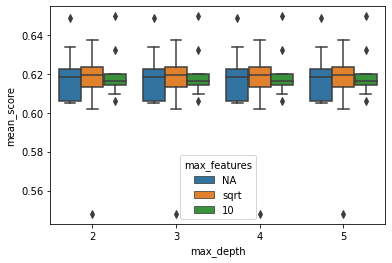

In [14]:
# GS results visualization
df = pd.DataFrame.from_records(gs_beva.cv_results_['params'])
df["mean_score"] = gs_beva.cv_results_['mean_test_score']
df["max_features"]= df["max_features"].fillna("NA")
sns.boxplot(data = df, y="mean_score", x= "max_depth", hue ="max_features")
plt.show()

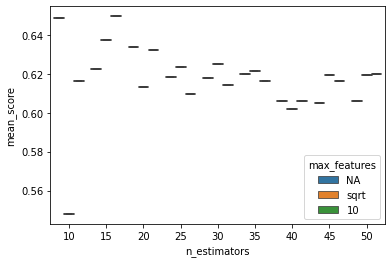

In [15]:
sns.boxplot(data = df, y="mean_score", x= "n_estimators", hue ="max_features")
plt.show()

In [16]:
permut_result_st, gs_st = run_RSF_and_calc_feature_importance(uke_bics.loc[sele_bics_ids,:], annot,  #test
                                                              dasl_bics.loc[sele_bics_ids,:], annot_dasl,# training
                                                              treatment_col = "bevacizumab",
                                                              treatment_value =0,
                                                                covariates = covariates,
                                                                surv_cols = [s+"_event",s+"_time"],
                                                                analysis_seed = analysis_seed,
                                                                n_permutations = n_permutations,
                                                                param_grid = param_grid
)
permut_result_st.columns = ["st_"+s+"."+x for x in permut_result_st.columns]

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 2, 'max_features': None, 'n_estimators': 20}
RSF scores: Test: 0.60 (train: 0.69)


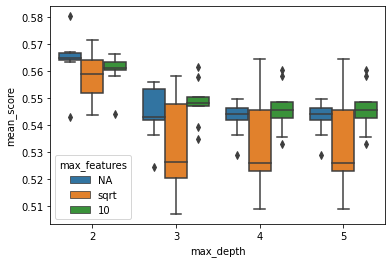

In [17]:
# GS results visualization
df = pd.DataFrame.from_records(gs_st.cv_results_['params'])
df["mean_score"] = gs_st.cv_results_['mean_test_score']
df["max_features"]= df["max_features"].fillna("NA")
sns.boxplot(data = df, y="mean_score", x= "max_depth", hue ="max_features")
plt.show()

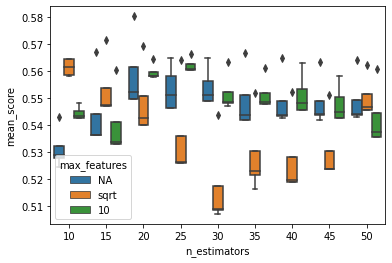

In [18]:
sns.boxplot(data = df, y="mean_score", x= "n_estimators", hue ="max_features")
plt.show()

In [19]:
shared_variables = [x for x in permut_result_beva.index.values if x in permut_result_st.index.values]
df = pd.concat([permut_result_beva.loc[shared_variables,:],
           permut_result_st.loc[shared_variables,:]],
          axis=1)
df["diff"] = df["beva_"+s+".importances_mean"] - df["st_"+s+".importances_mean"]
d = df.sort_values(by = "beva_"+s+".importances_mean",ascending = False).loc[:,["beva_"+s+".importances_mean","st_"+s+".importances_mean","diff"]]
d = d.loc[d["beva_"+s+".importances_mean"]>0,:]
#d = d.loc[d["diff"]>0,:]
sele_features_beva =  d.index.values

sele_bics_beva = [int(x.replace("bic","")) for x in sele_features_beva if not x in covariates]
print(sele_features_beva)
print(sele_bics_beva)                 
d.loc[sele_features_beva,:]

['age' 'bic70' 'bic84' 'bic130' 'bic90' 'OP_2' 'bic109']
[70, 84, 130, 90, 109]


,beva_OS.importances_mean,st_OS.importances_mean,diff
age,0.040348,0.009414,0.030934
bic70,0.020886,-0.001172,0.022058
bic84,0.013131,0.000000,0.013131
bic130,0.010104,0.000000,0.010104
bic90,0.005135,0.000000,0.005135
OP_2,0.001002,0.045254,-0.044252
bic109,0.000989,0.000475,0.000514


In [20]:
shared_variables = [x for x in permut_result_beva.index.values if x in permut_result_st.index.values]
df = pd.concat([permut_result_beva.loc[shared_variables,:],
           permut_result_st.loc[shared_variables,:]],
          axis=1)
df["diff"] = df["st_"+s+".importances_mean"] - df["beva_"+s+".importances_mean"]
d = df.sort_values(by = "st_"+s+".importances_mean",ascending = False).loc[:,["beva_"+s+".importances_mean","st_"+s+".importances_mean","diff"]]
#d = d.loc[d["st_"+s+".importances_mean"]>0,:]
#d = d.loc[d["diff"]>0,:]
sele_features_st =  d.index.values
sele_bics_st = [int(x.replace("bic","")) for x in sele_features_st if not x in covariates]
print(sele_features_st)
print(sele_bics_st)                 
#d

['OP_2' 'FIGO_IV' 'OP_1' 'age' 'bic60' 'bic95' 'bic109' 'bic168' 'bic85'
 'bic155' 'bic103' 'bic144' 'bic72' 'bic83' 'bic59' 'FIGO_IIIC' 'bic90'
 'bic130' 'bic84' 'bic70' 'bic41' 'bic117' 'bic62']
[60, 95, 109, 168, 85, 155, 103, 144, 72, 83, 59, 90, 130, 84, 70, 41, 117, 62]


In [21]:
shared_variables = [x for x in permut_result_beva.index.values if x in permut_result_st.index.values]
df = pd.concat([permut_result_beva.loc[shared_variables,:],
           permut_result_st.loc[shared_variables,:]],
          axis=1)
df.loc[list(set(sele_features_beva)|set(sele_features_st)),:].sort_values(by="beva_"+s+".importances_mean",ascending = False)
df.loc[list(set(sele_features_beva)|set(sele_features_st)),["beva_"+s+".importances_mean", "st_"+s+".importances_mean"]].sort_values(by="beva_"+s+".importances_mean",ascending = False)

,beva_OS.importances_mean,st_OS.importances_mean
age,0.040348,0.009414
bic70,0.020886,-0.001172
bic84,0.013131,0.000000
bic130,0.010104,0.000000
bic90,0.005135,0.000000
OP_2,0.001002,0.045254
bic109,0.000989,0.000475
bic59,0.000000,0.000000
bic62,0.000000,-0.006273
bic41,0.000000,-0.001187


# Predictive candidates

In [22]:
sele_bics_ids = sele_bics_beva
sele_bics_ids

[70, 84, 130, 90, 109]

In [23]:
#s = "OS"
s, sele_bics_ids# = [84, 130, 72,95,85]


('OS', [70, 84, 130, 90, 109])

In [24]:
from bic_survival_tests import test_predictive_biclusters
uke_os = test_predictive_biclusters(uke_bics.loc[sele_bics_ids,:],
                                annot,
                                treatment_col= "bevacizumab",
                                time_col = s+"_time",
                                event_col = s+"_event",
                                covariates = covariates, min_n_samples=10)

Biclusters tested: 5


In [25]:
fdr = 1 # 0.05
passed_uke = set(uke_os.loc[uke_os["min_adj_pval"]<fdr,:].index.values)
print(len(passed_uke))
uke_os.loc[passed_uke,:].sort_values(by=["min_adj_pval","min_pval"])#.head(30)

5


,bg.pval,bg.HR,bg.CI95,bg.beva,bg.st,bg.covar_excl,bic.pval,bic.HR,bic.CI95,bic.beva,bic.st,bic.covar_excl,direction,predictive,bevacizumab_eff,bic.pval_BH,bg.pval_BH,min_adj_pval,min_pval
90,0.002677,0.371431,"(0.19458866811754102, 0.708988594645302)",33,74,[],0.410723,0.7827,"(0.43659289303253185, 1.4031803219057117)",34,40,[],UP,low,pos,0.634355,0.007704,0.007704,0.002677
84,0.003082,0.408457,"(0.22574659321570492, 0.7390472470560943)",39,60,[],0.968537,1.012052,"(0.5580419556101323, 1.835434692091807)",28,54,[],DOWN,high,pos,0.968537,0.007704,0.007704,0.003082
130,0.004821,0.407069,"(0.21789966238664504, 0.7604667506921334)",35,78,[],0.17221,0.635371,"(0.33130581497885814, 1.218501722853906)",32,36,[],UP,low,pos,0.430525,0.008036,0.008036,0.004821
70,0.218892,0.738448,"(0.4554113029414694, 1.1973923105653326)",44,64,[],0.00525,0.255455,"(0.09798134044989751, 0.6660193861119814)",23,50,[],DOWN,low,pos,0.026252,0.218892,0.026252,0.005250
109,0.029728,0.548936,"(0.31963595720650123, 0.942731410388946)",39,79,[],0.507484,0.782094,"(0.378091022304504, 1.6177871712330978)",28,35,[],UP,low,pos,0.634355,0.03716,0.037160,0.029728


### Predictive biclusters
* model with interaction term

In [26]:
from bic_survival_tests import test_predictive_with_interaction

In [27]:
surv_data = annot.loc[:,covariates+["bevacizumab",s+"_time",s+"_event"]]
#formula = "age + FIGO_IIIC + FIGO_IV + OP_1 + OP_2 + bevacizumab * bic"

df = test_predictive_with_interaction(uke_bics.loc[sele_bics_ids,:],
                                     surv_data,
                                     covariates=covariates,
                                     treatment_col = "bevacizumab",
                                     duration_col=s+"_time",
                                     event_col= s+"_event",
                                     min_n_samples=10,
                                    )

print(df.shape[0])
df.loc[df["bevacizumab:bic_pval_BH"]<1]#.sort_values(by = ["bevacizumab:bic_pval_BH","bevacizumab:bic_pval"])

formula: FIGO_IIIC + FIGO_IV + OP_1 + OP_2 + age + bevacizumab * bic
5


,bevacizumab_bic,bevacizumab_bg,standard_bic,standard_bg,bevacizumab:bic_pval,bevacizumab:bic_HR,bevacizumab:bic_CI95,bevacizumab_pval,bevacizumab_HR,bevacizumab_CI95,bic_pval,bic_HR,bic_CI95,bevacizumab:bic_pval_BH,bevacizumab_pval_BH,bic_pval_BH
109,28,39,35,79,0.533283,1.305883,"(3.023702244656595, 0.563987879640907)",0.035232,0.564534,"(0.9612050456462706, 0.33156115449504897)",0.162024,0.704984,"(1.1507559307929232, 0.43189261688929065)",0.533283,0.04404,0.60331
130,32,35,36,78,0.28696,1.590459,"(3.736437188422762, 0.6769981683293766)",0.02241,0.498892,"(0.9062100877132652, 0.2746527342243978)",0.241324,0.741784,"(1.222571407450595, 0.45007014243340937)",0.3587,0.037349,0.60331
70,23,44,50,64,0.090687,0.426239,"(1.1447391819397987, 0.1587086935501607)",0.25569,0.758768,"(1.2213585163676157, 0.47138417898120805)",0.522168,0.861652,"(1.3594783823560797, 0.546123820708642)",0.226717,0.25569,0.851661
84,28,39,54,60,0.069179,2.095788,"(4.65512046354022, 0.9435475974347897)",0.007067,0.456542,"(0.8076980466074382, 0.2580556432520973)",0.681329,1.100887,"(1.7417003483229294, 0.6958441149051381)",0.226717,0.026149,0.851661
90,34,33,40,74,0.183871,1.753155,"(4.0125190401907584, 0.7659906215311988)",0.01046,0.446619,"(0.8277944736884252, 0.24096412752149396)",0.857916,1.04299,"(1.653507820072745, 0.6578906149136144)",0.306452,0.026149,0.857916


In [28]:
v = "bevacizumab:bic_"
df.loc[:,[v+"pval",v+"pval_BH",v+"HR",v+"CI95"]]

,bevacizumab:bic_pval,bevacizumab:bic_pval_BH,bevacizumab:bic_HR,bevacizumab:bic_CI95
109,0.533283,0.533283,1.305883,"(3.023702244656595, 0.563987879640907)"
130,0.28696,0.3587,1.590459,"(3.736437188422762, 0.6769981683293766)"
70,0.090687,0.226717,0.426239,"(1.1447391819397987, 0.1587086935501607)"
84,0.069179,0.226717,2.095788,"(4.65512046354022, 0.9435475974347897)"
90,0.183871,0.306452,1.753155,"(4.0125190401907584, 0.7659906215311988)"


In [29]:
# prognostic
v = "bic_"
df.loc[:,[v+"pval",v+"pval_BH",v+"HR",v+"CI95"]]

,bic_pval,bic_pval_BH,bic_HR,bic_CI95
109,0.162024,0.60331,0.704984,"(1.1507559307929232, 0.43189261688929065)"
130,0.241324,0.60331,0.741784,"(1.222571407450595, 0.45007014243340937)"
70,0.522168,0.851661,0.861652,"(1.3594783823560797, 0.546123820708642)"
84,0.681329,0.851661,1.100887,"(1.7417003483229294, 0.6958441149051381)"
90,0.857916,0.857916,1.04299,"(1.653507820072745, 0.6578906149136144)"


# validation in DASL 

In [30]:
print(len(passed_uke))

5


In [31]:
dasl_os = test_predictive_biclusters(dasl_bics.loc[sele_bics_ids,:],
                                 annot_dasl, 
                                 treatment_col= "bevacizumab",
                                 time_col = s+"_time",
                                 event_col = s+"_event",
                                 covariates = covariates)

passed_dasl = dasl_os.loc[dasl_os["min_adj_pval"]<fdr,:].index.values
print(len(passed_dasl))
dasl_os.loc[passed_dasl,:]

Biclusters tested: 5
5


,bg.pval,bg.HR,bg.CI95,bg.beva,bg.st,bg.covar_excl,bic.pval,bic.HR,bic.CI95,bic.beva,bic.st,bic.covar_excl,direction,predictive,bevacizumab_eff,bic.pval_BH,bg.pval_BH,min_adj_pval,min_pval
84,0.00065,0.507434,"(0.34358167164567155, 0.7494261787624645)",101,94,[],0.870703,1.036488,"(0.6731995827634121, 1.595823674480094)",97,85,[],DOWN,high,pos,0.870703,0.003251,0.003251,0.000650
130,0.016754,0.680032,"(0.49580485061963775, 0.932714111809023)",174,151,[],0.516382,1.28076,"(0.6065744876064966, 2.704276159732652)",24,28,[],UP,low,pos,0.645478,0.041885,0.041885,0.016754
109,0.056494,0.723036,"(0.5181118931198211, 1.0090112411728958)",158,137,[],0.350371,0.758663,"(0.4249133259210897, 1.3545559139230452)",40,42,[],UP,low,pos,0.645478,0.074227,0.074227,0.056494
70,0.059382,0.697446,"(0.4795440113652737, 1.0143612044004409)",129,111,[],0.395345,0.824636,"(0.5286505761478579, 1.2863405186414003)",69,68,[],UP,low,pos,0.645478,0.074227,0.074227,0.059382
90,0.128555,0.719959,"(0.4712948809260568, 1.0998240133441384)",104,92,[],0.102513,0.720491,"(0.48610311785410787, 1.0678941329636042)",94,87,[],UP,high,pos,0.512567,0.128555,0.128555,0.102513


In [32]:
surv_data = annot_dasl.loc[:,covariates+["bevacizumab",s+"_time",s+"_event"]]

df = test_predictive_with_interaction(dasl_bics.loc[sele_bics_ids,:],
                                     surv_data,
                                     covariates=covariates,
                                     treatment_col = "bevacizumab",
                                     duration_col=s+"_time",
                                     event_col= s+"_event",
                                     min_n_samples=10,
                                    )

print(df.shape[0])
df.loc[df["bevacizumab:bic_pval"]<1,:]

formula: FIGO_IIIC + FIGO_IV + OP_1 + OP_2 + age + bevacizumab * bic
5


,bevacizumab_bic,bevacizumab_bg,standard_bic,standard_bg,bevacizumab:bic_pval,bevacizumab:bic_HR,bevacizumab:bic_CI95,bevacizumab_pval,bevacizumab_HR,bevacizumab_CI95,bic_pval,bic_HR,bic_CI95,bevacizumab:bic_pval_BH,bevacizumab_pval_BH,bic_pval_BH
84,97,101,85,94,0.013626,2.061498,"(3.6626561476239523, 1.1602987123755164)",0.000872,0.521548,"(0.765142267308274, 0.3555061834814814)",0.092818,0.696451,"(1.0619485568462221, 0.4567493788511178)",0.068132,0.004359,0.464091
130,24,174,28,151,0.134611,1.765634,"(3.7182502945929206, 0.838422279062523)",0.018169,0.683782,"(0.9373307237194068, 0.49881826597958895)",0.205042,1.389459,"(2.3108044257349167, 0.8354651195415561)",0.336527,0.045424,0.512604
109,40,158,42,137,0.64217,1.165657,"(2.225188098007718, 0.6106257015251766)",0.038762,0.704447,"(0.9820678679895953, 0.5053066764936925)",0.391227,1.217259,"(1.9079397159991922, 0.7766070325364207)",0.802712,0.048452,0.600345
90,94,104,87,92,0.924283,1.02802,"(1.8176228097011748, 0.5814325652507583)",0.10461,0.706222,"(1.0749129620374676, 0.4639902443751798)",0.480276,1.156823,"(1.7335656589552983, 0.7719572702790062)",0.924283,0.10461,0.600345
70,69,129,68,111,0.513614,1.211685,"(2.1557462935852136, 0.6810547417196099)",0.03317,0.668198,"(0.9683237278701086, 0.46109497565196284)",0.837782,0.957765,"(1.4476797370578485, 0.6336445952479888)",0.802712,0.048452,0.837782


In [33]:
uke_bics.loc[84,"genes"]

{'ENSG00000144407',
 'ENSG00000205359',
 'ENSG00000225882',
 'ENSG00000249721',
 'ENSG00000250682'}

In [34]:
v = "bevacizumab:bic_"
df.loc[:,[v+"pval",v+"pval_BH",v+"HR",v+"CI95"]]

,bevacizumab:bic_pval,bevacizumab:bic_pval_BH,bevacizumab:bic_HR,bevacizumab:bic_CI95
84,0.013626,0.068132,2.061498,"(3.6626561476239523, 1.1602987123755164)"
130,0.134611,0.336527,1.765634,"(3.7182502945929206, 0.838422279062523)"
109,0.64217,0.802712,1.165657,"(2.225188098007718, 0.6106257015251766)"
90,0.924283,0.924283,1.02802,"(1.8176228097011748, 0.5814325652507583)"
70,0.513614,0.802712,1.211685,"(2.1557462935852136, 0.6810547417196099)"


In [35]:
v = "bic_"
df.loc[:,[v+"pval",v+"pval_BH",v+"HR",v+"CI95"]]

,bic_pval,bic_pval_BH,bic_HR,bic_CI95
84,0.092818,0.464091,0.696451,"(1.0619485568462221, 0.4567493788511178)"
130,0.205042,0.512604,1.389459,"(2.3108044257349167, 0.8354651195415561)"
109,0.391227,0.600345,1.217259,"(1.9079397159991922, 0.7766070325364207)"
90,0.480276,0.600345,1.156823,"(1.7335656589552983, 0.7719572702790062)"
70,0.837782,0.837782,0.957765,"(1.4476797370578485, 0.6336445952479888)"


In [36]:
uke_os.loc[passed_dasl,["direction","predictive","bevacizumab_eff",
                        "bg.pval","bic.pval","bg.HR","bic.HR"]]

,direction,predictive,bevacizumab_eff,bg.pval,bic.pval,bg.HR,bic.HR
84,DOWN,high,pos,0.003082,0.968537,0.408457,1.012052
130,UP,low,pos,0.004821,0.17221,0.407069,0.635371
109,UP,low,pos,0.029728,0.507484,0.548936,0.782094
70,DOWN,low,pos,0.218892,0.00525,0.738448,0.255455
90,UP,low,pos,0.002677,0.410723,0.371431,0.7827


In [37]:
dasl_os.loc[passed_dasl,["direction","predictive","bevacizumab_eff",
                         "bg.pval","bic.pval","bg.HR","bic.HR"]]

,direction,predictive,bevacizumab_eff,bg.pval,bic.pval,bg.HR,bic.HR
84,DOWN,high,pos,0.00065,0.870703,0.507434,1.036488
130,UP,low,pos,0.016754,0.516382,0.680032,1.28076
109,UP,low,pos,0.056494,0.350371,0.723036,0.758663
70,UP,low,pos,0.059382,0.395345,0.697446,0.824636
90,UP,high,pos,0.128555,0.102513,0.719959,0.720491


In [38]:
reproduced_bic_ids = uke_os.loc[passed_dasl,["predictive","bevacizumab_eff"]] == dasl_os.loc[passed_dasl,["predictive","bevacizumab_eff"]]
reproduced_bic_ids =reproduced_bic_ids.apply(lambda row: np.all(row),axis=1)
reproduced_bic_ids = list(reproduced_bic_ids[reproduced_bic_ids].index)
reproduced_bic_ids 

[84, 130, 109, 70]

### KM-plots predictive 

(0.5580419556101323, 1.835434692091807)
bicluster p-val.=9.69e-01, adj.p-val.=9.69e-01, HR=1.01(0.56,1.84);
(0.22574659321570492, 0.7390472470560943)
background p-val.=3.08e-03, adj.p-val.=7.70e-03, HR=0.41(0.23,0.74);
84 82


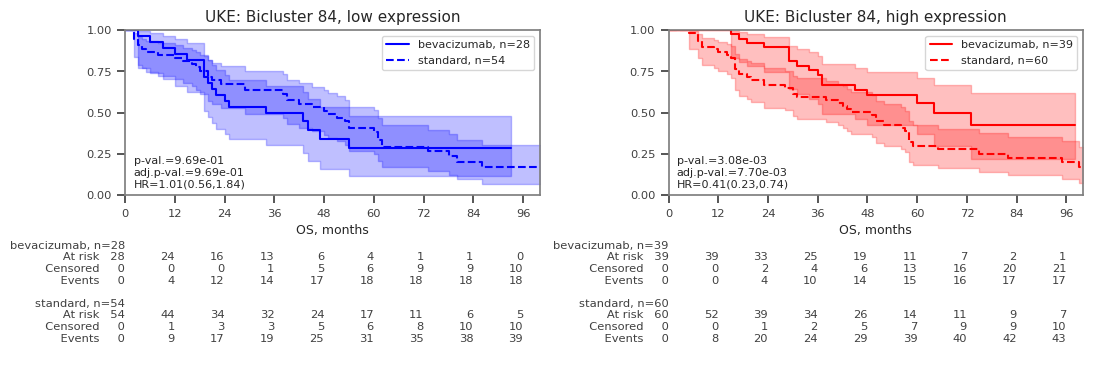

In [39]:
from bic_survival_plots import plot_KM_predictive
bic_id =  84
bic_samples = uke_bics.loc[bic_id,"samples"].intersection(set(annot.index.values))
plot_KM_predictive(bic_samples, annot, uke_os, bic_id,
                   uke_bics.loc[bic_id,"direction"],
                   surv_time = s+"_time",
                   surv_event= s+"_event",
                   cohort = "UKE",
                   xlabel = s+", months",
                   add_counts=True,
                   label_pos=(2,0.05),
                   figsize = (11,4),
                   e = "expression",
                  )
                    

(0.6731995827634121, 1.595823674480094)
bicluster p-val.=8.71e-01, adj.p-val.=8.71e-01, HR=1.04(0.67,1.60);
(0.34358167164567155, 0.7494261787624645)
background p-val.=6.50e-04, adj.p-val.=3.25e-03, HR=0.51(0.34,0.75);
84 182


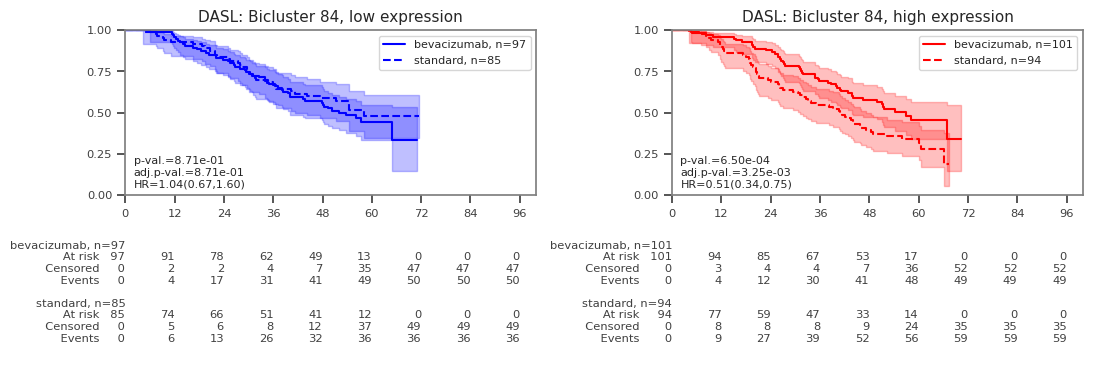

In [40]:
bic_samples = dasl_bics.loc[bic_id,"samples"].intersection(set(annot_dasl.index.values))
d = dasl_bics.loc[bic_id,"direction"]
plot_KM_predictive(bic_samples, annot_dasl, dasl_os, bic_id, d,
                    surv_time = s+"_time", surv_event= s+"_event",
                       cohort = "DASL",
                   label_pos=(2,0.05),
                  figsize = (11,4),
                   e = "expression",
                  add_counts = True,
                  )

### Plot biclusters 

In [41]:
color_dict = {"bevacizumab":{0:"lightgrey",1:"darkgreen"},
              "consensusOV":{
    "MES_consensus":"orange",
    "PRO_consensus":"lime",
    "IMR_consensus": "magenta",
    "DIF_consensus":"cyan"
    },
    "subtype":{"MES":"orange", "mesenchymal":"orange",
    "PRO":"lime", 'proliferative':'lime',
    "IMR": "magenta", 'immunoreactive':'magenta',
    "DIF":"cyan",'differentiated':"cyan",
    "MES_consensus":"orange",
    "PRO_consensus":"lime",
    "IMR_consensus": "magenta",
    "DIF_consensus":"cyan",
    },
    "Bentink":{
    'Angiogenic':'violet',
    'nonAngiogenic':'gold'},
}

subt_dir = "../data/OVcancer_subtypes/"
uke_subt = pd.read_csv(subt_dir+"UKE181_OVconsensus_subtypes.tsv",sep ="\t",index_col=0)
dasl_subt = pd.read_csv(subt_dir+"DASL_Kommoss_OVconsensus_subtypes.tsv",sep ="\t",index_col=0)

dasl_subt["subtype"]=dasl_subt["consensusOV"]
uke_subt["subtype"]=uke_subt["consensusOV"]

In [42]:
exprs_z_rn = rename_genes_in_exprs(exprs_z.copy())

In [43]:
reproduced_bic_ids  = [84]

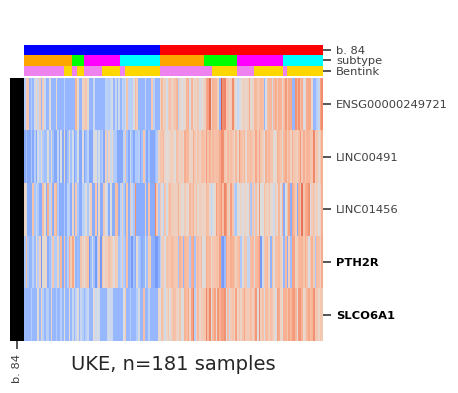

In [46]:
from unpast.utils.figs import draw_heatmap2

i = reproduced_bic_ids  
b = rename_genes_in_biclusters(uke_bics.loc[i,:].copy())
fs = 14

fig = draw_heatmap2(exprs_z_rn.loc[:,annot.index], b,
                    annot=uke_subt.loc[:,["subtype","Bentink"]],
                    color_dict=color_dict,
              bicluster_colors="redblue",
              figsize = (5,4), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.04, 0.04/10*8),
              bic_prefix = "b. ",
              legend_n_cols=0,
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              highlight_row_labels=["PTH2R","SLCO6A1",
              "ADIPOQ","CIDEA","CIDEC","PLIN1","CD300LG","FABP4","RERGL",
                                   "EMX2","EMX2OS","FAM181A","CTCFL"],
                no_row_colors = False,cluster_rows=False
             )
ax = fig[0].ax_heatmap
tmp = ax.set_xlabel("UKE, n=%s samples"%annot.shape[0], fontsize=fs)
plt.show()

In [47]:
cols = ["bic"+str(x) for x in reproduced_bic_ids]
df = pd.DataFrame(np.zeros((annot.shape[0],len(cols))),
             index=annot.index,
             columns=cols)
for bic_id in reproduced_bic_ids:
    df.loc[uke_bics.loc[bic_id,"samples"],"bic"+str(bic_id)]=1
df = df.applymap(lambda x: int(x))
df.to_csv("UKE_181.design.tsv",sep ="\t")


In [48]:
exprs_z_dasl = zscore(exprs_dasl.copy())
exprs_z_rn_dasl = rename_genes_in_exprs(exprs_z_dasl.copy())

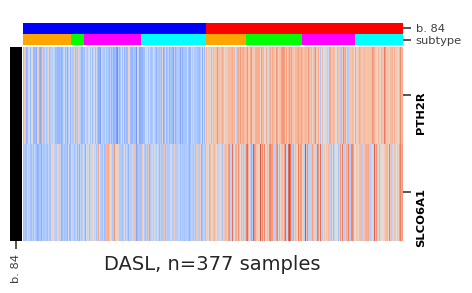

In [50]:
i = reproduced_bic_ids
b = rename_genes_in_biclusters(dasl_bics.loc[i,:].copy())

fig = draw_heatmap2(exprs_z_rn_dasl.loc[:,annot_dasl.index], b,
                    annot=dasl_subt.loc[:,["subtype"]],
                    color_dict=color_dict,
                    bicluster_colors="redblue",
                    figsize = (5,3), 
                    dendrogram_ratio=(0.05,0.05),
                    colors_ratio=(0.05/5*3, 0.05),
                    bic_prefix = "b. ",
                    legend_n_cols=0,
                    no_cbar=True,
                    col_labels = False,
                    row_labels = True,
                    highlight_row_labels=["PTH2R","SLCO6A1",
                    "ADIPOQ","CIDEA","CIDEC","PLIN1","CD300LG", "FABP4","RERGL",
                                       "EMX2","EMX2OS","FAM181A"],
no_row_colors = False,cluster_rows=False
             )
ax = fig[0].ax_heatmap
tmp = ax.set_xlabel("DASL, n=%s samples"%annot_dasl.shape[0], fontsize=fs)
plt.show()

In [51]:
cols = ["bic"+str(x) for x in reproduced_bic_ids]
df = pd.DataFrame(np.zeros((exprs_dasl.shape[1],len(cols))),
             index=exprs_dasl.columns,
             columns=cols)
for bic_id in reproduced_bic_ids:
    df.loc[dasl_bics.loc[bic_id,"samples"],"bic"+str(bic_id)]=1
df = df.applymap(lambda x: int(x))
df.to_csv("DASL_377.design.tsv",sep ="\t")

# DE analysis

(reads limma's output tables; run notebook with DE analysis before running this tab)

In [53]:
lfc = 1
p = 0.05#1e-5 #0.01
de_shared = {}
query_gset_dict = {}
for i in reproduced_bic_ids:
    de_shared[i]={}
    de = pd.read_csv("bic"+str(i)+"_UKE181.DE.tsv",sep = "\t")
    de = de.loc[de["adj.P.Val"]<p,:]
    de_up = de.loc[de["logFC"]>lfc,:].index.values
    de_down = de.loc[de["logFC"]<-lfc,:].index.values
    de2 = pd.read_csv("bic"+str(i)+"_DASL377.DE.tsv",sep = "\t")
    de2 = de2.loc[de2["adj.P.Val"]<p,:]
    de2_up = de2.loc[de2["logFC"]>lfc,:].index.values
    de2_down = de2.loc[de2["logFC"]<-lfc,:].index.values
    print("\t UKE bic.%s:"%i,len(de_up),len(de_down) )
    print("\t DASL bic.%s:"%i,len(de2_up),len(de2_down) )
    if uke_bics.loc[i,"direction"] == dasl_bics.loc[i,"direction"]:
        shared_up = set(de_up).intersection(set(de2_up))
        shared_down = set(de_down).intersection(set(de2_down))
    else:
        shared_up = set(de_up).intersection(set(de2_down))
        shared_down = set(de_down).intersection(set(de2_up))
    print("\t shared.%s:"%i,len(shared_up),len(shared_down) )
    de_shared[i]["genes"] = shared_up | shared_down
    de_shared[i]["genes_up"] = shared_up
    de_shared[i]["genes_down"] = shared_down
    print(i,len(shared_up | shared_down))
    query_gset_dict.update({"UKEbic"+str(i)+"_up":uke_bics.loc[i,"genes_up"],
                            "UKEbic"+str(i)+"_down":uke_bics.loc[i,"genes_down"],
                            "UKE"+str(i)+"_up":set(de_up),
                            "UKE"+str(i)+"_down":set(de_down)})
    query_gset_dict.update({"DASLbic"+str(i)+"_up":dasl_bics.loc[i,"genes_up"],
                            "DASLbic"+str(i)+"_down":dasl_bics.loc[i,"genes_down"],
                           "DASL"+str(i)+"_up":set(de2_up),
                            "DASL"+str(i)+"_down":set(de2_down)})
    query_gset_dict.update({"shared_"+str(i)+"_up":shared_up,"shared_"+str(i)+"_down":shared_down}
    )
de_shared=pd.DataFrame.from_dict(de_shared).T
#de_shared=de_shared.loc[reproduced_bic_ids,:]
de_shared

	 UKE bic.84: 7 305
	 DASL bic.84: 12 37
	 shared.84: 1 13
84 14


,genes,genes_down,genes_up
84,"{ENSG00000141096, ENSG00000176204, ENSG0000028...","{ENSG00000141096, ENSG00000176204, ENSG0000028...",{ENSG00000122133}


In [54]:
b = 84

In [55]:
#sorted(set(uke.index).intersection(uke_bics.loc[b,"genes"]))

In [56]:
from scipy.stats import fisher_exact

In [57]:
def read_limma(tsv_file,exprs):
    df = pd.read_csv(tsv_file,sep ="\t",index_col=0)
    #df = df.loc[df["adj.P.Val"]<0.05,:]
    cols = list(df.columns.values)
    df["gene"] = df.index
    df["gene"] = df["gene"].apply(lambda x: rename_gene(x))
    df = df.loc[:,["gene"]+cols]
    df = add_avg_exprs(df, exprs,col_name = "avgLog2exprs")
    df = df.sort_values(by="adj.P.Val" )
    df["rank"] = df["adj.P.Val"].rank()
    return df

def add_avg_exprs(df, exprs,col_name = "avgLog2exprs"):
    df[col_name ] = np.nan
    shared  =  sorted(set(df.index.values).intersection(set(exprs.index.values)))
    df.loc[shared,col_name ] = exprs.loc[shared ,:].mean(axis=1)
    return df

In [58]:
de_uke = read_limma("bic"+str(b)+"_UKE181.DE.tsv",exprs)
de_dasl = read_limma("bic"+str(b)+"_DASL377.DE.tsv",exprs_dasl)
shared_genes = set(exprs.index).intersection(set(exprs_dasl.index))
print("shared_genes",len(shared_genes))


de_uke  =de_uke.loc[de_uke["adj.P.Val"]<p,:]
de_uke  = de_uke.loc[de_uke["logFC"].abs()>lfc,:]

de_dasl  = de_dasl.loc[de_dasl["adj.P.Val"]<p,:]
de_dasl  = de_dasl.loc[de_dasl["logFC"].abs()>lfc,:]


uke_signif = set(de_uke.index)
dasl_signif = set(de_dasl.index)
print("all","signif. in UKE:",len(uke_signif),"in DASL:" , len(dasl_signif))
uke_signif = set(de_uke.index).intersection(shared_genes)
dasl_signif = set(de_dasl.index).intersection(shared_genes)
print("shared","signif. in UKE:",len(uke_signif),"in DASL:" , len(dasl_signif))

signif_both = set(de_uke.index).intersection(set(de_dasl.index))
signif_any = set(de_uke.index).union(set(de_dasl.index)).intersection(shared_genes)
print("significant in both",len(signif_both))
print("significant in at least one",len(signif_any))
o = len(signif_both)
uke_only = len(uke_signif.intersection(shared_genes))-len(signif_both)
dasl_only = len(dasl_signif.intersection(shared_genes))-len(signif_both)
print([[o, uke_only],[dasl_only, len(shared_genes) - uke_only - dasl_only - o ]])
statistics, pval = fisher_exact([[o, uke_only],[dasl_only, len(shared_genes) - uke_only - dasl_only + o ]], alternative="greater")
print("overlap p-value:%.2e"%pval )


shared_genes 15592
all signif. in UKE: 312 in DASL: 49
shared signif. in UKE: 118 in DASL: 46
significant in both 14
significant in at least one 150
[[14, 104], [32, 15442]]
overlap p-value:1.75e-19


In [59]:
de_uke = read_limma("bic"+str(b)+"_UKE181.DE.tsv",exprs)
de_dasl = read_limma("bic"+str(b)+"_DASL377.DE.tsv",exprs_dasl)

uke = de_uke.loc[:,:].copy()
uke["in bic."+str(b)] = 0
uke.loc[sorted(set(uke.index).intersection(uke_bics.loc[b,"genes"])),"in bic."+str(b)] = 1

uke = uke.loc[sorted(signif_any),["gene","in bic."+str(b),"logFC","adj.P.Val","avgLog2exprs","rank"]]
uke.columns = ["gene","in bic."+str(b)]+["UKE_"+x for x in ["logFC","adj.P.Val","avgLog2exprs","rank"]]

dasl = de_dasl.loc[sorted(signif_any),["logFC","adj.P.Val","avgLog2exprs","rank"]]
dasl.columns = ["DASL_"+x for x in dasl.columns]

df = pd.concat([uke,dasl],axis=1)
# check the sign of log2FC is the same
d = df.loc[df["UKE_logFC"]*df["DASL_logFC"]<0,:]
if d.shape[0]>0:
    print("the sign does not match:")
    print(len(set(d.index).intersection(shared_genes)))

# keep only DE genes with the same lFC sign
df = df.loc[df["UKE_logFC"]*df["DASL_logFC"]>0,:]

d = df.loc[df["UKE_logFC"].abs()>=lfc,:]
d = d.loc[d["UKE_adj.P.Val"]<p,:]
uke_signif = set(d.index)

d = df.loc[df["DASL_logFC"].abs()>=lfc,:]
d = d.loc[d["DASL_adj.P.Val"]<p,:]
dasl_signif = set(d.index)
print("signif. in UKE:",len(uke_signif),"signif. in in DASL:" , len(dasl_signif))
signif_both = uke_signif.intersection(dasl_signif)
signif_any = uke_signif.union(dasl_signif)#.intersection(shared_genes)
print("significant in both",len(signif_both))
print("significant in at least one dataset",len(signif_any))

df["avg_rank"] = df.loc[:,["UKE_rank","DASL_rank"]].mean(axis=1)
df = df.sort_values("avg_rank")
# logFC sign is  flipped to compare benefit vs no benefit groups
df["UKE_logFC"] = df["UKE_logFC"] * -1
df["DASL_logFC"] = df["DASL_logFC"] * -1
df.index.names = ["gene_id"]
###df.to_csv("tables/bic"+str(b)+"_DE.UKE_and_DASL.tsv",sep="\t")
df.head(20)

the sign does not match:
17
signif. in UKE: 103 signif. in in DASL: 44
significant in both 14
significant in at least one dataset 133


,gene,in bic.84,UKE_logFC,UKE_adj.P.Val,UKE_avgLog2exprs,UKE_rank,DASL_logFC,DASL_adj.P.Val,DASL_avgLog2exprs,DASL_rank,avg_rank
gene_id,,,,,,,,,,,
ENSG00000205359,SLCO6A1,1,3.610710,6.827249e-40,2.401567,2.0,1.930636,5.788021e-33,7.656167,2.0,2.00
ENSG00000084453,SLCO1A2,0,2.597286,5.831795e-08,4.685145,20.0,1.081157,3.788957e-13,6.121194,5.0,12.50
ENSG00000144407,PTH2R,1,2.918521,9.135928e-07,5.776959,36.0,3.935389,1.469472e-86,9.507736,1.0,18.50
ENSG00000127928,GNGT1,0,1.926976,5.165309e-07,5.084154,35.0,1.381456,3.006943e-13,7.939428,4.0,19.50
ENSG00000133710,SPINK5,0,1.976104,1.730418e-07,6.814876,26.0,1.040379,8.840066e-07,10.245764,83.0,54.50
ENSG00000176204,LRRTM4,0,1.873221,1.084620e-04,2.435715,96.0,1.027032,1.230601e-07,7.997956,31.5,63.75
ENSG00000124092,CTCFL,0,2.054593,5.926518e-04,7.741535,135.0,1.576616,3.686130e-07,11.021222,51.0,93.00
ENSG00000280409,LINC01101,0,1.224104,1.341776e-03,3.846328,183.0,1.643674,4.389658e-10,9.318886,12.0,97.50
ENSG00000267313,,0,2.385125,1.080929e-05,2.741302,61.0,0.479585,1.998411e-05,6.795675,218.0,139.50


In [60]:
df.loc[[x for x in df.index if x in signif_both],:].head(20)

,gene,in bic.84,UKE_logFC,UKE_adj.P.Val,UKE_avgLog2exprs,UKE_rank,DASL_logFC,DASL_adj.P.Val,DASL_avgLog2exprs,DASL_rank,avg_rank
gene_id,,,,,,,,,,,
ENSG00000205359,SLCO6A1,1,3.610710,6.827249e-40,2.401567,2.0,1.930636,5.788021e-33,7.656167,2.0,2.00
ENSG00000084453,SLCO1A2,0,2.597286,5.831795e-08,4.685145,20.0,1.081157,3.788957e-13,6.121194,5.0,12.50
ENSG00000144407,PTH2R,1,2.918521,9.135928e-07,5.776959,36.0,3.935389,1.469472e-86,9.507736,1.0,18.50
ENSG00000127928,GNGT1,0,1.926976,5.165309e-07,5.084154,35.0,1.381456,3.006943e-13,7.939428,4.0,19.50
ENSG00000133710,SPINK5,0,1.976104,1.730418e-07,6.814876,26.0,1.040379,8.840066e-07,10.245764,83.0,54.50
ENSG00000176204,LRRTM4,0,1.873221,1.084620e-04,2.435715,96.0,1.027032,1.230601e-07,7.997956,31.5,63.75
ENSG00000124092,CTCFL,0,2.054593,5.926518e-04,7.741535,135.0,1.576616,3.686130e-07,11.021222,51.0,93.00
ENSG00000280409,LINC01101,0,1.224104,1.341776e-03,3.846328,183.0,1.643674,4.389658e-10,9.318886,12.0,97.50
ENSG00000198054,DSCR8,0,1.526098,4.379622e-03,1.156431,290.5,1.615826,3.478067e-07,9.448314,47.5,169.00


In [61]:
xls_flie = 'tables/S3_DE_genes_p-value'+str(p)+'_lfc'+str(lfc)+'.xlsx'
print(xls_flie)

tables/S3_DE_genes_p-value0.05_lfc1.xlsx


### bic. 84: genes DE in both UKE and DASL

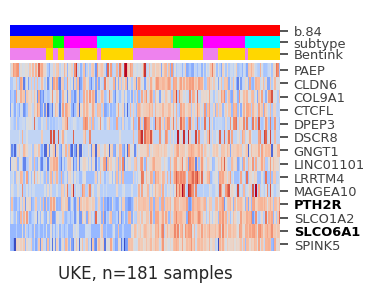

In [112]:
fs = 12
i = [84]#eproduced_bic_ids
b = uke_bics.loc[i,:].copy()
b["genes"] = de_shared["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
b["genes_up"] = de_shared["genes_up"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
b["genes_down"] = de_shared["genes_down"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))


fig = draw_heatmap2(exprs_z_rn.loc[:,annot.index], b,
                    annot=uke_subt.loc[:,["subtype", "Bentink"]],
                    color_dict=color_dict,
              bicluster_colors="redblue",
              figsize = (4,3), 
              dendrogram_ratio=(0.05,0.05),
              colors_ratio=(0.03, 0.05),
              bic_prefix = "b.",
              legend_n_cols=0,
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              color_range=(-3,3),
              highlight_row_labels=['PTH2R', 'SLCO6A1', 'LINC01456', 'ENSG00000249721', 'LINC00491',#"PTH2R","SLCO6A1",
              "ADIPOQ","CIDEA","CIDEC","PLIN1","CD300LG"],
                no_row_colors = True,cluster_rows=False
             )
ax = fig[0].ax_heatmap
tmp = ax.set_xlabel("UKE, n=%s samples"%annot.shape[0], fontsize=fs)
plt.show()

In [113]:
de_shared["genes_down"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes])).values

array([{'MAGEA10', 'CLDN6', 'CTCFL', 'LINC01101', 'LRRTM4', 'COL9A1', 'SPINK5', 'DSCR8', 'GNGT1', 'SLCO6A1', 'PTH2R', 'DPEP3', 'SLCO1A2'}],
      dtype=object)

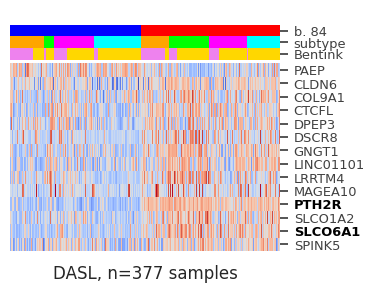

In [114]:
b = dasl_bics.loc[i,:].copy()
b["genes"] = de_shared["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
b["genes_up"] = de_shared["genes_up"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
b["genes_down"] = de_shared["genes_down"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))

fig = draw_heatmap2(exprs_z_rn_dasl.loc[:,annot_dasl.index], b,
                    annot=dasl_subt.loc[:,["subtype", "Bentink"]],
                    color_dict=color_dict,
                    bicluster_colors="redblue",
                    figsize = (4,3), 
                    dendrogram_ratio=(0.05,0.05),
                    colors_ratio=(0.03, 0.05),
                    bic_prefix = "b. ",
                    legend_n_cols=0,
                    no_cbar=True,
                    col_labels = False,
                    row_labels = True,
                    color_range=(-3,3),
                    highlight_row_labels=['PTH2R', 'SLCO6A1', 'LINC01456', 'ENSG00000249721', 'LINC00491',#"PTH2R","SLCO6A1",
                    "ADIPOQ","CIDEA","CIDEC","PLIN1","CD300LG"],
                    no_row_colors = True,cluster_rows=False
             )
ax = fig[0].ax_heatmap
tmp = ax.set_xlabel("DASL, n=%s samples"%annot_dasl.shape[0], fontsize=fs)
plt.show()

## Gene set overrepresentation

In [62]:
# only genes presenting in both UKE and DASL are accounted
import gseapy
names = gseapy.get_library_name()

#annot = pd.read_csv("../data/UKE.sample_annotation_v4_181samples.tsv",sep ="\t",index_col=0)
shared_samples = sorted(set(exprs.columns.values).intersection(set(annot.index.values)))
shared_genes = sorted(set(exprs.index.values).intersection(set(exprs_dasl.index.values)))
#exprs = exprs.loc[:,shared_samples]
#annot = annot.loc[shared_samples,:]

bg_gene_names = [rename_gene(x) for x in shared_genes if len(rename_gene(x))>0]
bg_gene_names = sorted(bg_gene_names)
exprs_g_names = exprs.loc[:,:].copy()
exprs_g_names.index = [rename_gene(x,keep_not_mapped=True) for x in exprs.index.values]
exprs_g_names = exprs_g_names.loc[bg_gene_names,:]
print(len(bg_gene_names))

15578


In [ ]:
gset_dbs = ['GO_Molecular_Function_2023', 
            'GO_Biological_Process_2023',
            'Reactome_2022',
            'WikiPathway_2023_Human',
            'KEGG_2021_Human',
            'CORUM',
            'GTEx_Tissues_V8_2023',
            'CellMarker_2024',
            'Descartes_Cell_Types_and_Tissue_2021',
            'Tabula_Sapiens']

gset_stats  = {}
## download databases, extract datasets, overlap with background
for db in gset_dbs:
    gset_stats[db] = {}
    gset_db = gseapy.get_library(name=db, organism='human')
    print(db, len(gset_db.keys()))
    for gs in gset_db.keys():
        gset = gset_db[gs]
        gset_exprs = set(gset).intersection(set(bg_gene_names))
        #print(db, gs, len(gset),len(gset_exprs), gset_exprs)
        gset_stats[db][gs] = gset_exprs

In [87]:
from openpyxl import load_workbook

xls_flie = 'tables/S4AB_ORA_p'+str(p)+'_lfc'+str(lfc)+'.xlsx'

with pd.ExcelWriter(xls_flie, engine='openpyxl') as writer:
    if not os.path.exists(xls_flie):
        pd.DataFrame().to_excel(writer, engine='openpyxl', sheet_name= "description")

    gso_bic = []
    for b in [84,130]:
        de = pd.read_csv("tables/bic"+str(b)+"_DE.UKE_and_DASL.tsv",sep="\t",index_col=0)
        de = de.loc[de["UKE_adj.P.Val"]<0.05,:]
        de = de.loc[de["DASL_adj.P.Val"]<0.05,:]
        if b == 84:
            de = de.loc[de["UKE_logFC"]>1,:]
            de = de.loc[de["DASL_logFC"]>1,:]
        if b == 130:
            de = de.loc[de["UKE_logFC"]<-1,:]
            de = de.loc[de["DASL_logFC"]<-1,:]
        gene_list = [x for x in list(de["gene"].values) if type(x)==str]
        gp_output = gseapy.enrichr(gene_list=gene_list,
                                   gene_sets=gset_dbs,
                                   organism="human",
                                   background=bg_gene_names,
                                   outdir="gseapy/",
                                   no_plot=True
                                  )
        res = gp_output.results
        res = res.loc[res["Adjusted P-value"]<0.05,:].copy()

        res['genes'] =  res['Genes'].apply(lambda x: " ".join(sorted(x.split(";"))))
        try:
            res["db_gset_size"] = res.apply(lambda x: len(gset_stats[x["Gene_set"]][x["Term"]]),axis=1)
        except:
            res["db_gset_size"] = np.nan
        res["overlap_size"] =  res['Genes'].apply(lambda x: len(sorted(x.split(";"))))

        res['bicluster_id'] = b
        cols = ['bicluster_id','Gene_set', 'Term',  'P-value', 'Adjusted P-value', 'Odds Ratio', 'Combined Score',
                'overlap_size', 'db_gset_size', 'genes']
        res = res.loc[res["overlap_size"]>1,cols]
        res["Gene_set_collection"] = res["Gene_set"]
        res["gene_set_name"] = res["Term"]

        cols = ['Gene_set_collection', 'gene_set_name', 'P-value', 'Adjusted P-value', 'Odds Ratio', 'overlap_size', 'genes']
        res = res.loc[:,cols].drop_duplicates(subset=["genes","Gene_set_collection"])
        res = res.sort_values(by = ["Adjusted P-value","Odds Ratio","genes","Gene_set_collection"],
                                ascending  = [True, False,True, True])
        res["bicluster"] = b
        gso_bic.append(res.loc[:,cols].copy())
        res = res.set_index("gene_set_name")
        print( "bic."+str(b), "genes in query set:",len(gene_list),"DB gene sets passed:", res.shape[0])
        ###res.to_excel(writer, engine='openpyxl', sheet_name= "bic."+str(b))

gso_bic = pd.concat(gso_bic)
gso_bic

bic.84 genes in query set: 13 DB gene sets passed: 6
bic.130 genes in query set: 101 DB gene sets passed: 306


,Gene_set_collection,gene_set_name,P-value,Adjusted P-value,Odds Ratio,overlap_size,genes
245,GTEx_Tissues_V8_2023,Testis Male 50-59 Up,0.000004,0.000251,125.902703,3,CTCFL DPEP3 MAGEA10
0,GO_Molecular_Function_2023,Sodium-Independent Organic Anion Transmembrane...,0.000035,0.000775,314.262626,2,SLCO1A2 SLCO6A1
22,GO_Biological_Process_2023,Sodium-Independent Organic Anion Transport (GO...,0.000035,0.001866,314.262626,2,SLCO1A2 SLCO6A1
246,GTEx_Tissues_V8_2023,Testis Male 20-29 Up,0.000377,0.007573,85.575758,2,CTCFL MAGEA10
75,Reactome_2022,Anti-inflammatory Response Favoring Leishmania...,0.000121,0.014822,39.610256,3,DPEP3 GNGT1 PTH2R
...,...,...,...,...,...,...,...
1930,CellMarker_2024,Endothelial Cell Artery Mouse,0.008835,0.047745,15.613131,2,CXCL12 FABP4
240,GO_Biological_Process_2023,Positive Regulation Of Cell Adhesion Mediated ...,0.005312,0.047839,20.824242,2,CCL21 SFRP2
241,GO_Biological_Process_2023,Energy Reserve Metabolic Process (GO:0006112),0.005312,0.047839,20.824242,2,GFPT2 LEP
242,GO_Biological_Process_2023,Antimicrobial Humoral Response (GO:0019730),0.005436,0.047839,9.080651,3,CTSG CXCL14 JCHAIN


In [63]:
gset_dbs2 = ['GO_Molecular_Function_2023',
 'Reactome_2022',
 'WikiPathway_2023_Human',
 'KEGG_2021_Human',
 'GTEx_Tissues_V8_2023',
 'CellMarker_2024',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Tabula_Sapiens']


In [64]:
xls_flie = 'tables/S4CD_GSEA_p'+str(p)+'_lfc'+str(lfc)+'.xlsx'

In [65]:
### GSEA
gsea_results = {}
for bic_id in reproduced_bic_ids:
    # make cls files
    #design = pd.read_csv("UKE_181.design.tsv",sep ="\t",index_col=0)
    #design = design.loc[:,["bic"+str(bic_id)]] 
    #exprs_g_names = exprs_g_names.loc[:,design.index]
    design = pd.read_csv("DASL_377.design.tsv",sep ="\t",index_col=0)
    design = design.loc[:,["bic"+str(bic_id)]] 
    exprs_g_names = exprs_dasl.loc[:,:].copy()
    exprs_g_names.index = [rename_gene(x,keep_not_mapped=True) for x in exprs_dasl.index.values]
    exprs_g_names = exprs_g_names.loc[bg_gene_names,:]
    
    groups = list(design["bic"+str(bic_id)].values)
    gr1, gr2 = 1, 0
    cls_file = 'bic'+str(bic_id)+'.cls'
    with open(cls_file, "w") as cl:
        line = f"{len(groups)} 2 1\n# "+str(gr1)+" "+str(gr2)+"\n"
        cl.write(line)
        cl.write(" ".join(map(str,groups)) + "\n")
        
    print("Gene set:", bic_id)
    # run gsea
    bic_gsea_results = []
    for db in gset_dbs2:
        print(db)
        gsea_res = gseapy.gsea(data=exprs_g_names, 
                     gene_sets=db,
                     cls= cls_file, 
                     permutation_type='phenotype',
                     permutation_num=1000, # reduce number to speed up test
                     max_size=200, min_size=5, # min and max DB gene set sizes
                     outdir=None,  # do not write output to disk
                     method='signal_to_noise',
                     seed=0,verbose=True)
        res = gsea_res.res2d.loc[:,:].copy()
        res["genes"] = res["Lead_genes"].apply(lambda x: " ".join(x.split(";")))
        res["overlap_size"] = res["Lead_genes"].apply(lambda x: len(x.split(";")))
        res["DB"] = db
        res["query_gene_set"] = bic_id
        bic_gsea_results.append(res)
    bic_gsea_results = pd.concat(bic_gsea_results,axis=0).sort_values(by = "FDR q-val")
    gsea_results[bic_id] = bic_gsea_results

2025-02-13 15:16:30,822 [INFO] Parsing data files for GSEA.............................


Gene set: 84
GO_Molecular_Function_2023


2025-02-13 15:16:32,617 [INFO] Enrichr library gene sets already downloaded in: /home/olya/.cache/gseapy, use local file
2025-02-13 15:16:32,640 [INFO] 0131 gene_sets have been filtered out when max_size=200 and min_size=5
2025-02-13 15:16:32,641 [INFO] 1016 gene_sets used for further statistical testing.....
2025-02-13 15:16:32,642 [INFO] Start to run GSEA...Might take a while..................
2025-02-13 15:18:53,551 [INFO] Congratulations. GSEApy ran successfully.................

2025-02-13 15:18:53,564 [INFO] Parsing data files for GSEA.............................


Reactome_2022


2025-02-13 15:18:56,328 [INFO] Enrichr library gene sets already downloaded in: /home/olya/.cache/gseapy, use local file
2025-02-13 15:18:56,389 [INFO] 0127 gene_sets have been filtered out when max_size=200 and min_size=5
2025-02-13 15:18:56,390 [INFO] 1691 gene_sets used for further statistical testing.....
2025-02-13 15:18:56,390 [INFO] Start to run GSEA...Might take a while..................
2025-02-13 15:23:39,335 [INFO] Congratulations. GSEApy ran successfully.................

2025-02-13 15:23:39,538 [INFO] Parsing data files for GSEA.............................


WikiPathway_2023_Human


2025-02-13 15:23:41,570 [INFO] Enrichr library gene sets already downloaded in: /home/olya/.cache/gseapy, use local file
2025-02-13 15:23:41,596 [INFO] 0036 gene_sets have been filtered out when max_size=200 and min_size=5
2025-02-13 15:23:41,597 [INFO] 0765 gene_sets used for further statistical testing.....
2025-02-13 15:23:41,598 [INFO] Start to run GSEA...Might take a while..................
2025-02-13 15:26:16,201 [INFO] Congratulations. GSEApy ran successfully.................

2025-02-13 15:26:16,476 [INFO] Parsing data files for GSEA.............................


KEGG_2021_Human


2025-02-13 15:26:18,227 [INFO] Enrichr library gene sets already downloaded in: /home/olya/.cache/gseapy, use local file
2025-02-13 15:26:18,247 [INFO] 0020 gene_sets have been filtered out when max_size=200 and min_size=5
2025-02-13 15:26:18,249 [INFO] 0300 gene_sets used for further statistical testing.....
2025-02-13 15:26:18,249 [INFO] Start to run GSEA...Might take a while..................
2025-02-13 15:27:24,019 [INFO] Congratulations. GSEApy ran successfully.................

2025-02-13 15:27:24,131 [INFO] Parsing data files for GSEA.............................


GTEx_Tissues_V8_2023


2025-02-13 15:27:25,693 [INFO] Enrichr library gene sets already downloaded in: /home/olya/.cache/gseapy, use local file
2025-02-13 15:27:25,717 [INFO] 0000 gene_sets have been filtered out when max_size=200 and min_size=5
2025-02-13 15:27:25,718 [INFO] 0511 gene_sets used for further statistical testing.....
2025-02-13 15:27:25,718 [INFO] Start to run GSEA...Might take a while..................
2025-02-13 15:29:03,988 [INFO] Congratulations. GSEApy ran successfully.................

2025-02-13 15:29:04,037 [INFO] Parsing data files for GSEA.............................


CellMarker_2024


2025-02-13 15:29:05,647 [INFO] Enrichr library gene sets already downloaded in: /home/olya/.cache/gseapy, use local file
2025-02-13 15:29:05,714 [INFO] 0210 gene_sets have been filtered out when max_size=200 and min_size=5
2025-02-13 15:29:05,715 [INFO] 1482 gene_sets used for further statistical testing.....
2025-02-13 15:29:05,716 [INFO] Start to run GSEA...Might take a while..................
2025-02-13 15:33:22,204 [INFO] Congratulations. GSEApy ran successfully.................

2025-02-13 15:33:22,279 [INFO] Parsing data files for GSEA.............................


Descartes_Cell_Types_and_Tissue_2021


2025-02-13 15:33:24,126 [INFO] Enrichr library gene sets already downloaded in: /home/olya/.cache/gseapy, use local file
2025-02-13 15:33:24,142 [INFO] 0018 gene_sets have been filtered out when max_size=200 and min_size=5
2025-02-13 15:33:24,143 [INFO] 0154 gene_sets used for further statistical testing.....
2025-02-13 15:33:24,144 [INFO] Start to run GSEA...Might take a while..................
2025-02-13 15:34:07,738 [INFO] Congratulations. GSEApy ran successfully.................

2025-02-13 15:34:07,962 [INFO] Parsing data files for GSEA.............................


Tabula_Sapiens


2025-02-13 15:34:09,465 [INFO] Enrichr library gene sets already downloaded in: /home/olya/.cache/gseapy, use local file
2025-02-13 15:34:09,497 [INFO] 0000 gene_sets have been filtered out when max_size=200 and min_size=5
2025-02-13 15:34:09,499 [INFO] 0469 gene_sets used for further statistical testing.....
2025-02-13 15:34:09,499 [INFO] Start to run GSEA...Might take a while..................
2025-02-13 15:35:41,616 [INFO] Congratulations. GSEApy ran successfully.................



In [96]:
cols = ['DB', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       #'Tag %', 'Gene %', 'query_gene_set'
        'Lead_genes', 'genes', 'overlap_size',
       ]
ds = "DASL"
with pd.ExcelWriter("tables/GSEA_"+ds+"_biclusters.xlsx", engine='openpyxl') as writer:
    if not os.path.exists(xls_flie):
        pd.DataFrame().to_excel(writer, engine='openpyxl', sheet_name= "description")
    for bic_id in reproduced_bic_ids:
        df = gsea_results[bic_id]
        df = df.sort_values(by = ["FDR q-val"],ascending  = [True])
        print("Tested gene sets:", df.shape[0])
        df = df.loc[df["FDR q-val"]<0.05,:]
        print("Passed gene sets:", df.shape[0])
        df = df.loc[:,cols]
        if df.shape[0]>0:
            df = df.set_index("Term")
            df.to_excel(writer,  engine='openpyxl', sheet_name= "bic."+str(bic_id))
            writer.save()


Tested gene sets: 6388
Passed gene sets: 0


# Prognostic value

In [97]:
s = "OS"
s, sele_bics_ids

('OS', [70, 84, 130, 90, 109])

In [105]:
from bic_survival_tests import test_biclusters_prognostic
from bic_survival_plots import plot_KM_prognostic

min_n_samples = 10
tr = 1 # 1 - beva , 0 - standard

cols = covariates+[s+"_event",s+"_time"]
surv_data = annot.copy().loc[annot["bevacizumab"]==tr,cols]

stats = test_biclusters_prognostic(uke_bics.copy().loc[sele_bics_ids,:],
                                   surv_data,
                                   surv_event = s +"_event",
                                   surv_time = s +"_time",
                                   covariates = covariates,
                                   min_n_samples=min_n_samples)
stats.loc[stats["adj_pval"]<fdr,:]

,n_up,n_down,HR,CI_l,CI_r,pval,adj_pval
84,39.0,28.0,0.396212,0.192884,0.813875,0.011712,0.036359
70,44.0,23.0,3.402823,1.274244,9.087121,0.014544,0.036359
90,34.0,33.0,1.736877,0.853550,3.534345,0.127732,0.212887
130,32.0,35.0,1.523793,0.656961,3.534371,0.326479,0.408098
109,28.0,39.0,1.064701,0.527341,2.149633,0.861165,0.861165


130 67 32 35


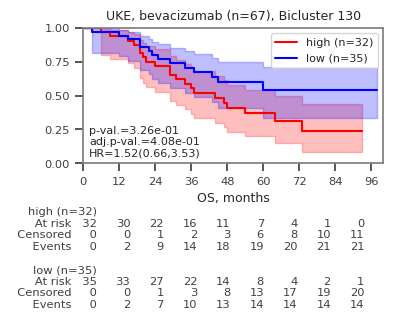

84 67 39 28


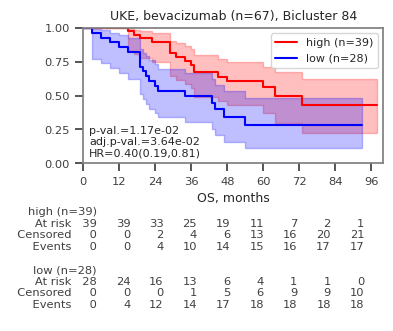

70 67 44 23


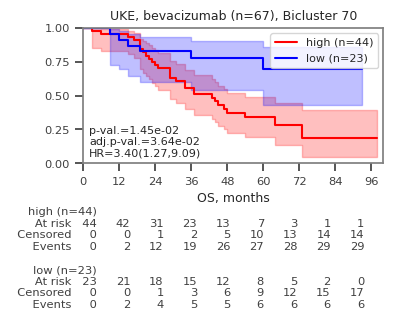

In [106]:
plot_KM_prognostic(uke_bics.loc[[130,84,70],:].copy(),
                   surv_data.copy(),
                   stats.copy(),
                   treatment ="bevacizumab", #
                   #treatment = "standard", #
                   surv_time=s+'_time',
                   surv_event=s+'_event',
                   xlabel= s+", months",
                   cohort = "UKE",
                   #linestyle="dashed",
                   add_counts=True,
                   figsize = (4,3.5),
                   # figsize=(3,2)
                  )

### DASL

In [100]:
cols = covariates+[s+"_event",s+"_time"]
surv_data = annot_dasl.copy().loc[annot_dasl["bevacizumab"]==tr,cols]

stats = test_biclusters_prognostic(dasl_bics.copy().loc[sele_bics_ids,:],
                                   surv_data,
                                   surv_event = s +"_event",
                                   surv_time = s +"_time",
                                   covariates = covariates,
                                   min_n_samples=min_n_samples)
stats.loc[stats["adj_pval"]<fdr,:]

,n_up,n_down,HR,CI_l,CI_r,pval,adj_pval
130,24.0,174.0,2.866639,1.649579,4.981647,0.000188,0.000938
84,101.0,97.0,0.651206,0.429929,0.986371,0.042894,0.107234
109,40.0,158.0,1.331765,0.821514,2.158939,0.245097,0.379873
70,69.0,129.0,1.243917,0.820509,1.885818,0.303898,0.379873
90,94.0,104.0,1.197381,0.792601,1.808880,0.392132,0.392132


130 198 24 174


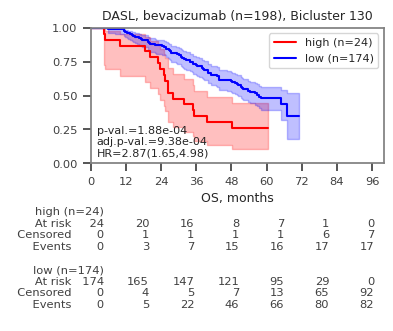

84 198 101 97


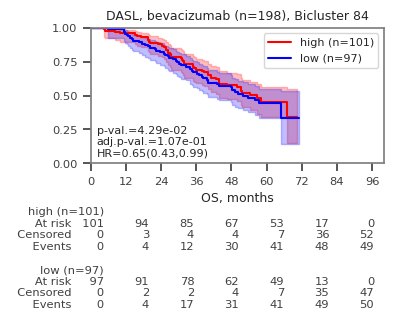

70 198 69 129


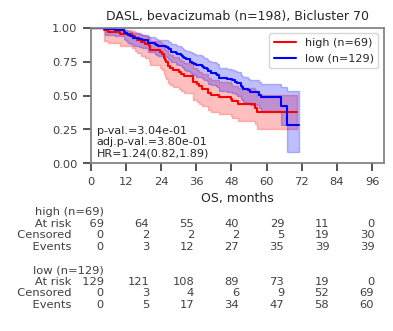

In [102]:
plot_KM_prognostic(dasl_bics.loc[[130,84,70] ,:],
                   surv_data,
                   stats,
                   treatment ="bevacizumab", #
                   #treatment ="standard", #
                   surv_time=s+'_time',
                   surv_event=s+'_event',
                   xlabel= s+", months",
                   cohort = "DASL",
                   #linestyle="dashed",
                   add_counts=True,
                   figsize = (4,3.5),
                  )

/home/olya/TUM/DESMOND/DESMOND2/OV_cancer_final/bevacizumab_ovca_signature/bic_survival_plots.py:310: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  linestyle='dashed',


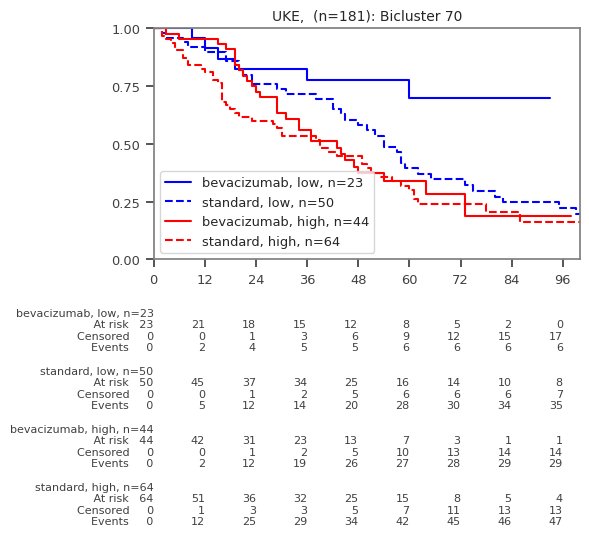

In [108]:
from bic_survival_plots import plot_KM_four
    
bic_id = 70 # 70
figsize = (5.5,3)
bic_samples = uke_bics.loc[bic_id,"samples"].intersection(set(annot.index.values))
d = uke_bics.loc[bic_id,"direction"]   

s = "OS"

plot_KM_four(bic_samples,
             annot, bic_id, 
             d,
             surv_time = s+"_time",
             surv_event= s+"_event",
             cohort = "UKE, ",
             add_counts=True,
             figsize=figsize,
             label_pos=(110,0.35),
              add_subplot=True
            )

/home/olya/TUM/DESMOND/DESMOND2/OV_cancer_final/bevacizumab_ovca_signature/bic_survival_plots.py:310: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  linestyle='dashed',


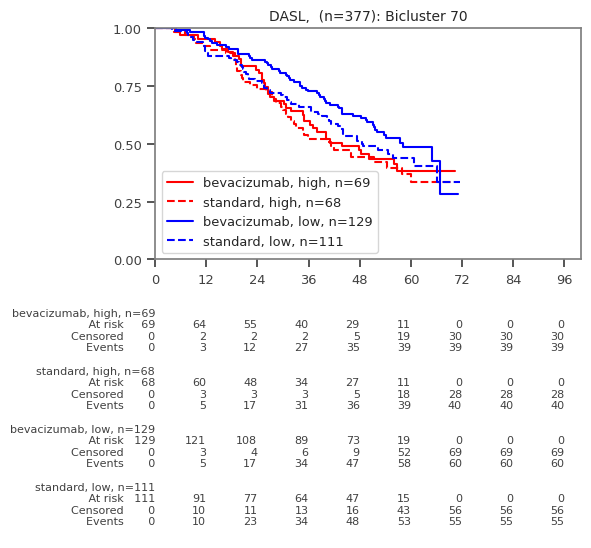

In [109]:
bic_samples = dasl_bics.loc[bic_id,"samples"].intersection(set(annot_dasl.index.values))
d = dasl_bics.loc[bic_id,"direction"]   

plot_KM_four(bic_samples,
             annot_dasl, bic_id, d,
             surv_time = s+"_time",
             surv_event= s+"_event",
             cohort = "DASL, ",
             add_counts=True,
             figsize=figsize,
             label_pos=(110,0.35),
            add_subplot=True)
                       